In [1]:
import torch
import random
import os

seed_value = 1   # 设定随机数种子
random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)  # 为了禁止hash随机化，使得实验可复现。
torch.manual_seed(seed_value)           # 为CPU设置随机种子
torch.backends.cudnn.deterministic = True



In [2]:
class XOR_classifier(torch.nn.Module):
    
    def __init__(self,input_dim,output_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_dim,64)
        self.fc2 = torch.nn.Linear(64,16)
        self.fc3 = torch.nn.Linear(16,output_dim)
        self.act = torch.nn.LeakyReLU()
        
    def forward(self,data):
        
        x = self.fc1(data)
        x = self.act(x)
        x = self.fc2(x)
        x = self.act(x)
        x = self.fc3(x)
        x = self.act(x)
        return x
        

train_data = [[0,0],[0,1],[1,0],[1,1]]
#train_label = [[0.1],[0.9],[0.9],[0.1]]
train_label = [[0],[1],[1],[0]]
grad_iter = 4

XOR = XOR_classifier(2,1)
learning_rate = 1e-1
epoch = 1000

criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(XOR.parameters(),
                lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=50,gamma=0.5)

for e in range(epoch):
    XOR.train(mode=True)
    running_loss = 0
    samples = random.sample([0,1,2,3],k=grad_iter)
    for iters in range(len(samples)):
        iter_id = samples[iters]
        XOR.zero_grad()
        optimizer.zero_grad()
        data = torch.Tensor(train_data[iter_id])
        label = torch.Tensor(train_label[iter_id])
        output = XOR(data)
        loss = criterion(output.cpu(), label)
        running_loss += loss.item()
    loss.backward()
    optimizer.step()
    lr_scheduler.step()
    if e%100 == 0:
        print(running_loss/(grad_iter*10))
        
        
with torch.no_grad():      
    for iter_id in range(len(train_data)):
        data = torch.Tensor(train_data[iter_id])
        label = torch.Tensor(train_label[iter_id])
        output = XOR(data)
        print(data,label,int(output>0.5))
        
    
torch.save(XOR.state_dict(),"./ohyeah.pth")



0.05020518261208053
0.02867020796984434
0.014220517873764039
0.011783886142075062
0.011150074750185012
0.01098319087177515
0.010940594412386418
0.010931637696921825
0.010928804613649845
0.010927962325513362
tensor([0., 0.]) tensor([0.]) 0
tensor([0., 1.]) tensor([1.]) 1
tensor([1., 0.]) tensor([1.]) 1
tensor([1., 1.]) tensor([0.]) 0


In [3]:
pretrain_path = './ohyeah.pth'
checkpoint = torch.load(pretrain_path, map_location=torch.device('cpu'))
savedXOR = XOR_classifier(2,1)
savedXOR.load_state_dict(checkpoint)
with torch.no_grad():      
    for iter_id in range(len(train_data)):
        data = torch.Tensor(train_data[iter_id])
        label = torch.Tensor(train_label[iter_id])
        output = XOR(data)
        print(data,label,int(output>0.5))

tensor([0., 0.]) tensor([0.]) 0
tensor([0., 1.]) tensor([1.]) 1
tensor([1., 0.]) tensor([1.]) 1
tensor([1., 1.]) tensor([0.]) 0


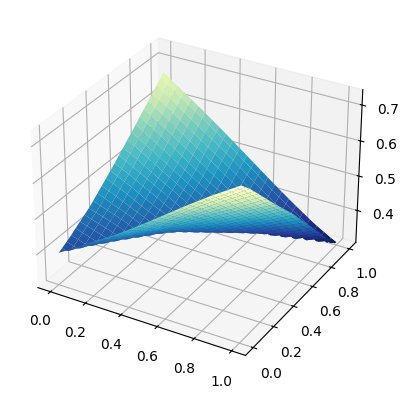

In [4]:
#需要安装 matplotlib
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import numpy as np
from matplotlib import cm

fig=plt.figure()
ax=fig.add_subplot(111,projection='3d')

u=np.linspace(0,1,100)
x,y=np.meshgrid(u,u)
z=np.zeros([100,100])
for i in range(100):
    for j in range(100):
        z[i,j] = float(savedXOR(torch.Tensor([x[0,i],y[j,0]])))
ax.plot_surface(x,y,z,rstride=4,cstride=4,cmap=cm.YlGnBu_r)
plt.show()